# Initial Setup

In [1]:
%%time

# Load packages.
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from matplotlib.pyplot import subplots
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS, summarize, contrast

from sklearn. discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

CPU times: user 2.63 s, sys: 333 ms, total: 2.96 s
Wall time: 2.81 s


# Laboratory

## Explore Smarket Data Set

In [2]:
# Load data.
Smarket = load_data("Smarket")
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


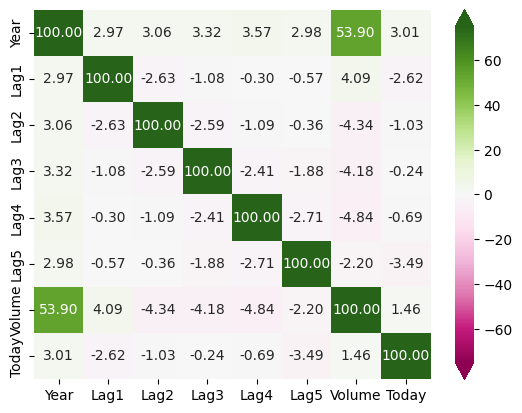

In [3]:
data = Smarket.drop(labels=["Direction"], axis=1).corr()
scale = 100
ax = sns.heatmap(
    data=scale * data,
    vmin=scale * -0.75,
    vmax=scale * 0.75,
    annot=True,
    fmt=".2f",
    cmap=plt.cm.PiYG,
    cbar_kws={"extend": "both"}
)

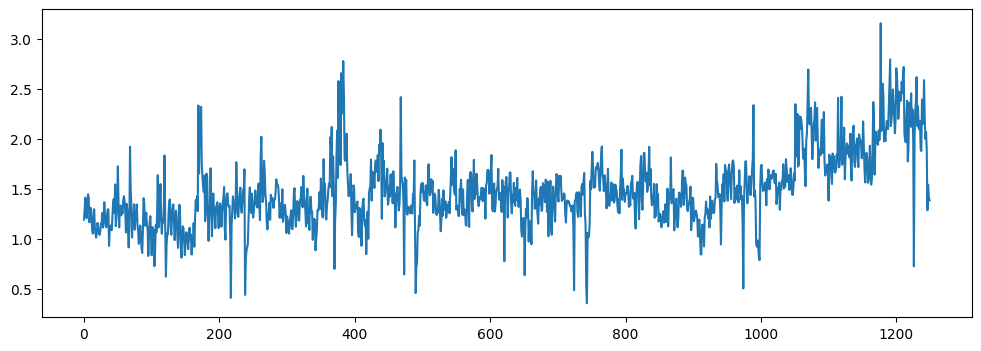

In [4]:
_ = Smarket.Volume.plot(figsize=(12, 4))

In [5]:
Smarket[Smarket.Direction == "Up"].shape

(648, 9)

In [6]:
Smarket[Smarket.Direction == "Down"].shape

(602, 9)

CPU times: user 2.28 s, sys: 423 ms, total: 2.7 s
Wall time: 2.07 s


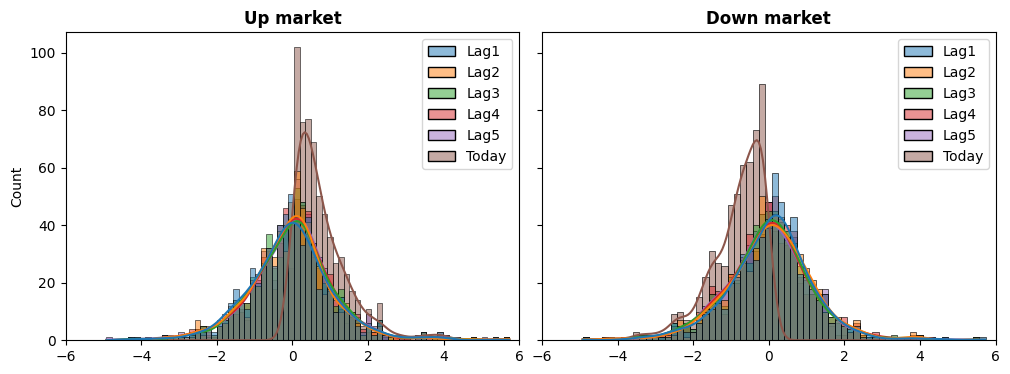

In [7]:
%%time

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
sns.histplot(
    data=Smarket[Smarket.Direction == "Up"].drop(labels=["Year", "Volume"], axis=1),
    kde=True,
    ax=axs[0]
)
sns.histplot(
    data=Smarket[Smarket.Direction == "Down"].drop(labels=["Year", "Volume"], axis=1),
    kde=True,
    ax=axs[1]
)
axs[0].set_xlim((-6, 6))
axs[0].set_title("Up market", weight="bold")
_ = axs[1].set_title("Down market", weight="bold")
plt.subplots_adjust(wspace=0.05)

## Logistic regression

In [8]:
%%time 

predictors = Smarket.columns.drop (["Today", "Direction", "Year"])

design = MS(predictors)
Xp = design.fit_transform(Smarket)
y = (Smarket.Direction == "Up").astype(int)
glm = sm.GLM(
    endog=y,
    exog=Xp,
    family=sm.families.Binomial()
)
results = glm.fit()
summarize(results)

CPU times: user 171 ms, sys: 8.28 ms, total: 180 ms
Wall time: 202 ms


,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [9]:
cut_prob = 0.5
nobs = Smarket.shape[0]

probs = results.predict ()
labels = np.array(nobs * ["Down"])
labels[probs > cut_prob] = "Up"

confusion_table(labels , Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [10]:
(507 + 145) /1250 , np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

In [11]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [12]:
X_train , X_test = Xp.loc[train], Xp.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [13]:
D = Smarket.Direction
L_train , L_test = D.loc[train], D.loc[~train]

In [14]:
labels = np.array(["Down"] * 252)
labels[probs > 0.5] = "Up"
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [15]:
100 * np.mean(labels == L_test), 100 * np.mean(labels != L_test)

(48.01587301587302, 51.98412698412699)

In [16]:
model = MS(["Lag1", "Lag2"]).fit(Smarket)
X = model.transform(Smarket)
X_train , X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array (252 * ["Down"])
labels[probs >0.5] = "Up"

confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [17]:
newdata = pd.DataFrame ({"Lag1": [1.2, 1.5], "Lag2": [1.1, -0.8]})
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

## Linear Discriminat Analysis

In [18]:
%%time

lda = LDA(store_covariance=True)

X_train, X_test = [M.drop(columns=["intercept"]) for M in [X_train, X_test]]
lda.fit(X_train , L_train)

CPU times: user 12.2 ms, sys: 8 µs, total: 12.2 ms
Wall time: 11.5 ms


LinearDiscriminantAnalysis(store_covariance=True)

In [19]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [20]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [21]:
lda.priors_

array([0.49198397, 0.50801603])

In [22]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [23]:
lda_pred = lda.predict(X_test)
lda_prob = lda.predict_proba(X_test)
confusion_table(lda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [24]:
np.sum(lda_prob[:,0] > 0.9)

0

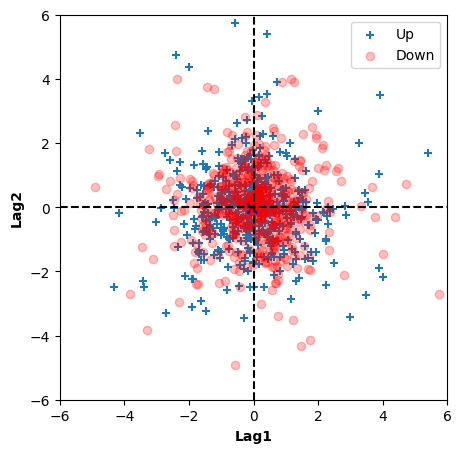

In [25]:
mask_up = y_train == 1
mask_down = y_train == 0
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X_train[mask_up].iloc[:, 0], X_train[mask_up].iloc[:, 1], alpha=1, marker="+", label="Up")
ax.scatter(X_train[mask_down].iloc[:, 0], X_train[mask_down].iloc[:, 1], color="red", alpha=0.25, label="Down")
ax.scatter(lda.means_[1, 0], lda.means_[1, 1], color="blue", marker="x", s=50)
ax.scatter(lda.means_[0, 0], lda.means_[0, 1], color="red", marker="x", s=50)
ax.set_xlabel(X_train.columns[0], weight="bold")
ax.set_ylabel(X_train.columns[1], weight="bold")
ax.set_xlim((-6, 6))
ax.set_ylim((-6, 6))
ax.axvline(ls="--", color="black")
ax.axhline(ls="--", color="black")
_ = plt.legend()